Set up a fully trained network in the NTK regime. We have a 1-hidden layer ReLU network.

$$
f_{W, a} (x)  = \dfrac{1}{\sqrt{m}} \sum_{i=1}^m a_r \sigma(w_r^\intercal x)
$$

The parameters are initialized randomly:
$$
w_r(0) \sim \mathcal{N}(0, \kappa^2 \mathbb{I}), a_r \sim \text{unif}(\{-1, 1 \}), \forall r \in [m]
$$

We fix the second layer $\mathbf{a}$ and optimize the first layer $\bf{W}$ on the quadratic objective function.
$$
\phi(\mathbf{W}) = \dfrac{1}{2} \sum_{i=1}^n (y_i - f_{\mathbf{W, a (x_i)}})^2
$$

In [48]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from estimator import classical_weights, V1_inspired_weights_same_center
from data_fns import load_mnist, load_cifar_10
from sklearn.model_selection import train_test_split

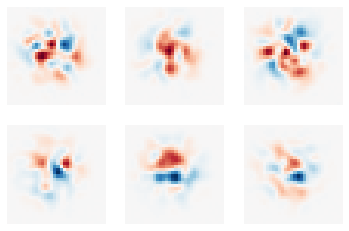

In [49]:
W = V1_inspired_weights_same_center(20, 1024, 5, 2, [14, 14])

fig = plt.figure()
for i in range(6):
    ax = fig.add_subplot(2, 3, i + 1)
    plt.imshow(W[i].reshape(32, 32), cmap='RdBu')
    plt.axis('off')
    cmap_lim = np.max(np.abs(W[i]))
    plt.clim(-cmap_lim, cmap_lim)

In [50]:
# load data
torch.cuda.set_device(0)
# train, train_labels, test, test_labels = load_mnist('./data/mnist/')
train, train_labels, test, test_labels = load_cifar_10(grayscale=True)

# convert data to tensors
train = torch.from_numpy(train).float().to('cuda')
train_labels = torch.from_numpy(train_labels).long().to('cuda')
test = torch.from_numpy(test).float().to('cuda')
test_labels = torch.from_numpy(test_labels).long().to('cuda')

# reshape
train_labels = train_labels.reshape(-1, 1)
test_labels = test_labels.reshape(-1, 1)

X_train, X_test, y_train, y_test = train, test, train_labels, test_labels

## Repeat similar experimental conditions as Du et. al. 2019. 
"Fine-Grained Analysis of Optimization and Generalization for Overparameterized Two-Layer Neural Networks "

In [51]:
# normalize inputs so that |x|_2 = 1
train /= torch.norm(train, dim=1).reshape(-1, 1)
test /= torch.norm(test, dim=1).reshape(-1, 1)

# load only the first two classes
train_idx = torch.logical_or(train_labels == 0, train_labels == 1).flatten()
test_idx = torch.logical_or(test_labels == 0, test_labels == 1).flatten()
train_binary = train[train_idx]

# We want label = 1 if first class and -1 otherwise.
# So we multiply original labels by -2 and add 1. Then, 0 -> 1, 1 -> -1
train_labels_binary = train_labels[train_idx] * -2 + 1
test_labels_binary = test_labels[test_idx] * -2 + 1

# We have 10k training samples and ~2k validation samples
X_test, y_test = test[test_idx], test_labels_binary
X_train, X_val, y_train, y_val = train_test_split(train_binary, train_labels_binary, train_size=9999, random_state=42)

In [52]:
# Set up the neural network. Hidden weights are trained but the output weights are fixed.
class NTK_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, kappa):
        super().__init__()
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(input_size, hidden_size)
        torch.nn.init.normal_(self.fc1.weight, mean=0, std=kappa ** 2)
        self.output = nn.Linear(hidden_size, output_size)
        torch.nn.init.uniform_(self.output.weight, a=-1, b=1)
        self.output.weight.requires_grad = False # freeze layer
        
    def forward(self, inputs):
        x = torch.relu(self.fc1(inputs))
        return 1 / np.sqrt(self.hidden_size) * self.output(x)

class bio_NTK_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, kappa):
        super().__init__()
        self.hidden_size = hidden_size
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc1.weight.data = torch.FloatTensor(V1_inspired_weights_same_center(hidden_size, input_size, t=5, l=2, m=[14, 14], 
                                                                                 scale=kappa ** 2))
        self.output = nn.Linear(hidden_size, output_size)
        torch.nn.init.uniform_(self.output.weight, a=-1, b=1)
        self.output.weight.requires_grad = False # freeze layer
        
    def forward(self, inputs):
        x = torch.relu(self.fc1(inputs))
        return 1 / np.sqrt(self.hidden_size) * self.output(x)

In [57]:
input_size, hidden_size, output_size, kappa = X_train.shape[1], 5000, 1, 1e-2
network = NTK_net(input_size, hidden_size, output_size, kappa).to('cuda')
bio_network = bio_NTK_net(input_size, hidden_size, output_size, kappa).to('cuda')

In [58]:
n_epochs, lr = 50000, 1e-3
loss_func = nn.MSELoss(reduction='sum')
loss_list = []
for i in range(n_epochs):
    optim = torch.optim.SGD(network.parameters(), lr=lr)
    optim.zero_grad()
    loss = loss_func(network(X_train), y_train.float()) / 2
    loss.backward()
    optim.step()
    loss_list.append(loss)
    if (i % 5000 == 0):
        print('Epoch: %d, loss=%0.3f' % (i, loss))

Epoch: 0, loss=4999.516
Epoch: 5000, loss=2653.425
Epoch: 10000, loss=2517.441
Epoch: 15000, loss=2403.009
Epoch: 20000, loss=2308.527
Epoch: 25000, loss=2229.461
Epoch: 30000, loss=2160.326
Epoch: 35000, loss=2099.663
Epoch: 40000, loss=2046.633
Epoch: 45000, loss=2000.512


In [ ]:
n_epochs, lr = 50000, 1e-3 
loss_func = nn.MSELoss(reduction='sum')
loss_list_bio = []
for i in range(n_epochs):
    optim = torch.optim.SGD(bio_network.parameters(), lr=lr)
    optim.zero_grad()
    loss = loss_func(bio_network(X_train), y_train.float()) / 2
    loss.backward()
    optim.step()
    loss_list_bio.append(loss)
    if (i % 10000 == 0):
        print('Epoch: %d, loss=%0.3f' % (i, loss))

Epoch: 0, loss=4998.000
Epoch: 10000, loss=2059.910
Epoch: 20000, loss=1820.740
Epoch: 30000, loss=1669.218


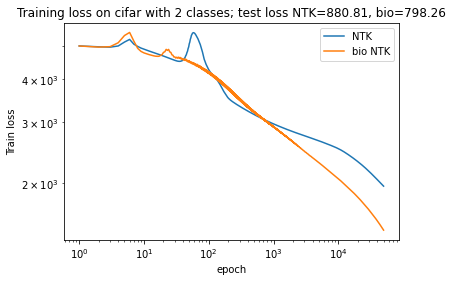

In [63]:
ntk_test_loss = loss_func(network(X_test), y_test)
bio_test_loss = loss_func(bio_network(X_test), y_test)
fig = plt.figure()
t = np.arange(1, n_epochs + 1)
plt.title('Training loss on cifar with 2 classes; test loss NTK=%0.2f, bio=%0.2f' % (ntk_test_loss, bio_test_loss))
plt.loglog(t, loss_list, label='NTK')
plt.loglog(t, loss_list_bio, label='bio NTK')
plt.xlabel('epoch')
plt.ylabel('Train loss')
plt.legend()
plt.savefig('results/NTK_analysis/cifar10_train_loss_h=%d_fixed_center.png' % hidden_size)

## kernel matrix analysis

In [64]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from estimator import V1_inspired_kernel_matrix
from data_fns import load_mnist, load_cifar_10
from sklearn.model_selection import train_test_split

In [65]:
dataset = 'cifar10'
if dataset == 'mnist':
    train, train_labels, test, test_labels = load_mnist('./data/mnist/')
elif dataset == 'cifar10':
    train, train_labels, test, test_labels = load_cifar_10(grayscale=True)

# normalize inputs so that |x|_2 = 1
train /= la.norm(train, axis=1).reshape(-1, 1)
test /= la.norm(test, axis=1).reshape(-1, 1)

# load only the first two classes
train_idx = np.logical_or(train_labels == 0, train_labels == 1).flatten()
test_idx = np.logical_or(test_labels == 0, test_labels == 1).flatten()
train_binary = train[train_idx]

# We want label = 1 if first class and -1 otherwise.
# So we multiply original labels by -2 and add 1. Then, 0 -> 1, 1 -> -1
train_labels_binary = train_labels[train_idx] * -2 + 1
test_labels_binary = test_labels[test_idx] * -2 + 1

# We have 10k training samples and ~2k validation samples
X_test, y_test = test[test_idx], test_labels_binary
X_train, X_val, y_train, y_val = train_test_split(train_binary, train_labels_binary, train_size=5000, random_state=None)

### Analyze the projection of eigenvalues of NTK kernel matrix on the labels

We know that for the network presented above, the NTK matrix is 

$$
H^\infty_{ij} = \dfrac{x_i^\intercal x_j (\pi - \arccos(x_i^\intercal x_j))}{2 \pi}, \; \; \forall i, j \in [n]
$$

In [66]:
# bio-inspired kernel matrix
input_size, t, l, m = X_train.shape[1], 5, 2, [14, 14]
C = V1_inspired_kernel_matrix(input_size, t, l, m, scale=1)
C_chol = la.cholesky(C)
X_train_proj = X_train @ C_chol
X_train_proj /= la.norm(X_train_proj, axis=1).reshape(-1, 1)

In [67]:
# regualar NTK
H_inf = (X_train @ X_train.T) * (np.pi - np.arccos(X_train @ X_train.T)) / (2 * np.pi)
H_inf[np.isnan(H_inf)] = 1 / 2

H_inf_bio = (X_train @ X_train.T) * (np.pi - np.arccos(X_train_proj @ X_train_proj.T)) / (2 * np.pi) 
H_inf_bio[np.isnan(H_inf_bio)] = 1 / 2

<ipython-input-67-3506a0544d43>:2: RuntimeWarning: invalid value encountered in arccos
  H_inf = (X_train @ X_train.T) * (np.pi - np.arccos(X_train @ X_train.T)) / (2 * np.pi)
<ipython-input-67-3506a0544d43>:5: RuntimeWarning: invalid value encountered in arccos
  H_inf_bio = (X_train @ X_train.T) * (np.pi - np.arccos(X_train_proj @ X_train_proj.T)) / (2 * np.pi)


In [68]:
# find eigenvalues, eigenvectors of the kernel matrices
eig_val, eig_vec = la.eigh(H_inf)
eig_val_bio, eig_vec_bio = la.eigh(H_inf_bio)

# flip to arrange in descending order
eig_val, eig_vec = np.flip(eig_val), np.flip(eig_vec, 1)
eig_val_bio, eig_vec_bio = np.flip(eig_val_bio), np.flip(eig_vec_bio, 1)

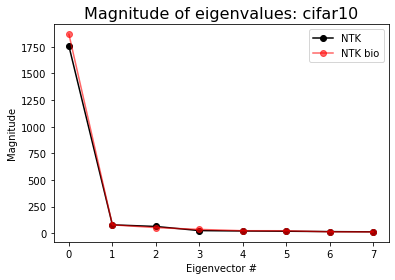

In [72]:
# plot eigenvalues
i = 8
fig = plt.figure()
plt.title('Magnitude of eigenvalues: %s' % dataset, fontsize=16)
plt.plot(eig_val[:i], 'k-o', label='NTK')
plt.plot(eig_val_bio[:i],'r-o', label='NTK bio', alpha=0.6)
plt.xlabel('Eigenvector #')
plt.ylabel('Magnitude')
# plt.xticks(np.arange(11))
plt.legend()
# plt.savefig('results/NTK_analysis/eigenvalues_%s.png' % dataset)

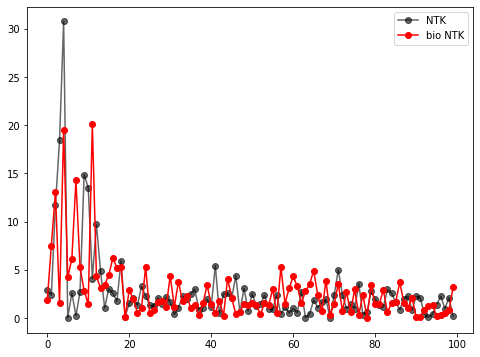

In [73]:
# find the projections of eigenvectors onto the data labels
proj = eig_vec.T @ y_train
proj_bio = eig_vec_bio.T @ y_train

i = 100
fig = plt.figure(figsize=(8, 6))
plt.plot(np.abs(proj)[:i], 'k-o', label='NTK', alpha=0.6)
plt.plot(np.abs(proj_bio)[:i], 'r-o', label='bio NTK')
plt.legend()
# plt.savefig('results/NTK_analysis/proj_eigenvecs_%s.png' % dataset)

In [74]:
# find the norm of the projections 
i = 5000
print('Norm for regular NTK', la.norm(np.abs(proj)[:i])) 
print('Norm for bio NTK', la.norm(np.abs(proj_bio)[:i]))    

Norm for regular NTK 70.71067811865476
Norm for bio NTK 70.71067811865473


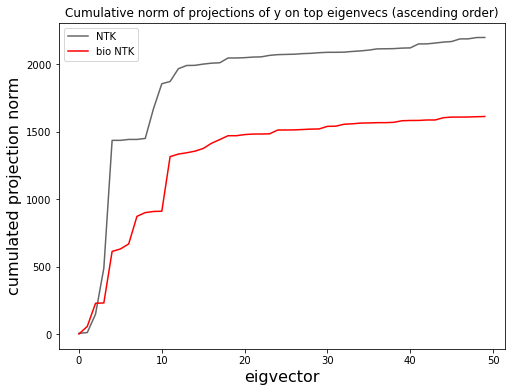

In [75]:
cum_norm_NTK = np.cumsum(proj ** 2)
cum_norm_NTK_bio = np.cumsum(proj_bio ** 2)

i = 50
fig = plt.figure(figsize=(8, 6))
plt.title('Cumulative norm of projections of y on top eigenvecs (ascending order)')
plt.plot(cum_norm_NTK[:i], 'k-', label='NTK', alpha=0.6)
plt.plot(cum_norm_NTK_bio[:i], 'r-', label='bio NTK')
plt.ylabel('cumulated projection norm', fontsize=16)
plt.xlabel('eigvector', fontsize=16)
plt.legend()

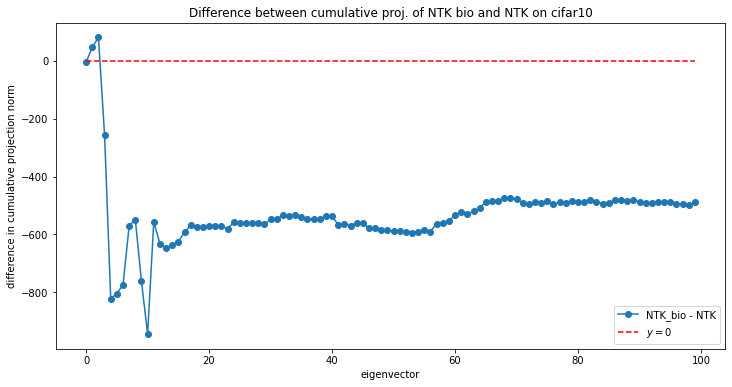

In [76]:
i = 100
fig = plt.figure(figsize=(12, 6))
plt.title('Difference between cumulative proj. of NTK bio and NTK on %s' % dataset)
plt.plot(np.array(cum_norm_NTK_bio)[:i] - np.array(cum_norm_NTK)[:i], '-o', label='NTK_bio - NTK')
plt.plot(np.arange(5000)[:i], np.zeros(5000)[:i], '--r', label=r'$y = 0$')
plt.ylabel('difference in cumulative projection norm')
plt.xlabel('eigenvector')
# plt.xticks(np.arange(i))
plt.legend()
# plt.savefig('results/NTK_analysis/diff_cum_proj_eigenvecs_%s.png' % dataset)

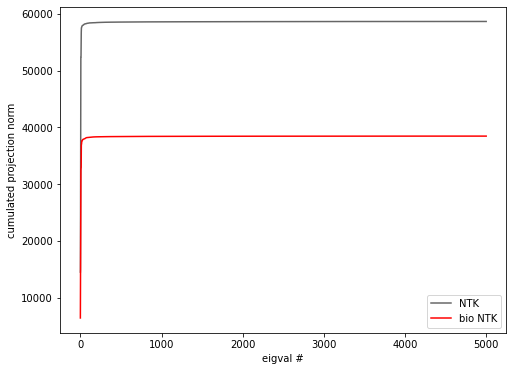

In [77]:
# find the projection times the eigenvalue square
proj_eigval = proj ** 2 * eig_val
proj_eigval_bio = proj_bio ** 2 * eig_val_bio

i = 5000
fig = plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(proj_eigval)[:i], 'k-', label='NTK', alpha=0.6)
plt.plot(np.cumsum(proj_eigval_bio)[:i], 'r-', label='bio NTK')
plt.ylabel('cumulated projection norm')
plt.xlabel('eigval #')
plt.legend()

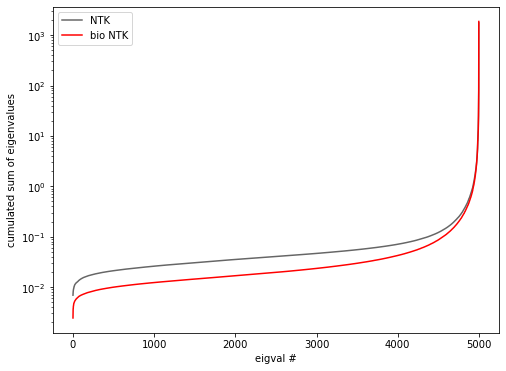

In [78]:
# plot cumulative sum of smallest eigenvalues
i = 5000
fig = plt.figure(figsize=(8, 6))
plt.semilogy(eig_val[::-1], 'k-', label='NTK', alpha=0.6)
plt.semilogy(eig_val_bio[::-1], 'r-', label='bio NTK')
plt.ylabel('cumulated sum of eigenvalues')
plt.xlabel('eigval #')
plt.legend()

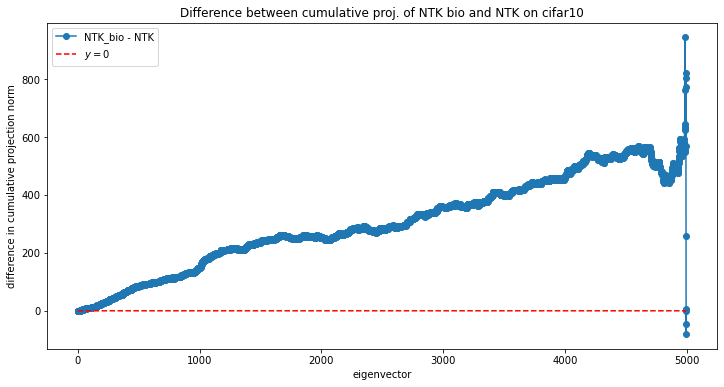

In [79]:
# look at the cumulative norm of the projections to eigenvecs in the ascending order
cum_norm_NTK_asc = np.cumsum(np.flip(proj) ** 2)
cum_norm_NTK_bio_asc = np.cumsum(np.flip(proj_bio) ** 2)

i = 5000
fig = plt.figure(figsize=(12, 6))
plt.title('Difference between cumulative proj. of NTK bio and NTK on %s' % dataset)
plt.plot(np.array(cum_norm_NTK_bio_asc)[:i] - np.array(cum_norm_NTK_asc)[:i], '-o', label='NTK_bio - NTK')
plt.plot(np.arange(5000)[:i], np.zeros(5000)[:i], '--r', label=r'$y = 0$')
plt.ylabel('difference in cumulative projection norm')
plt.xlabel('eigenvector')
# plt.xticks(np.arange(i))
plt.legend()
